In [5]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import random
import numpy as np
import json
import seaborn as sns

In [6]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [7]:
def get_clumps(directory,snp_type):
    '''
    Input: directory with all plink .clumped files to be aggregated
    Output: dataframe with INDEX SNP, p-value, association paramter
    '''
    #get clumped files
    files=os.listdir(directory)
    file_lst=[x for x in files if ".clumped" in x]
    
    if snp_type == "index":
    
        #iterate through all clumped files and extract index snps
        snps=[]
        assoc=[]
        p=[]

        for x in file_lst:
            file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
            for i,row in file.iterrows():
                snps.append(row["SNP"])
                p.append(row["P"])
                assoc.append(x.split(".clump.clumped")[0])
    
        df=pd.DataFrame({"snps":snps,"file":assoc,"p-value":p})
        return(df)
    
    if snp_type == "all":
        snps=[]
        indexsnp=[]
        assoc=[]
        p=[]

        for x in file_lst:
            file=pd.read_csv(directory+"/"+x, delim_whitespace=True)
            for i,row in file.iterrows():
                for y in row["SP2"].split("(1),"):
                    snps.append(y)
                    indexsnp.append(row["SNP"])
                    p.append(row["P"])
                    assoc.append(x.split(".clump.clumped")[0])
                
        df=pd.DataFrame({"indexsnps":indexsnp,"snps":snps,"file":assoc,"p-value":p})
        df=df[~(df["snps"]=="")]
        df=df[~(df["snps"]=="NONE")]
        df["snps"]=df["snps"].str.split("(").str[0]
        return(df)

In [8]:
def map_rsid(x):
    '''
    Input: SNP format (chr:bp:minor:major)
    Output: tuple (variant,rsid)
    '''
    try:
        var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[2]+">"+x.split(":")[3]
        rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
    except:
        try:
            var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
            rs=mv.getvariants(var,fields='dbsnp.rsid')[0]["dbsnp"]["rsid"]
        except:
            var="chr"+x.split(":")[0]+":g."+x.split(":")[1]+x.split(":")[3]+">"+x.split(":")[2]
            rs=""
    
    return (var,rs)

In [9]:
#get index snps from TPM association analysis
tpm_snps=get_clumps("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/clump/hla/tpm","all")
firebrowse_snps=get_clumps("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/clump/hla/firebrowse","all")
pancan_snps=get_clumps("/cellar/users/mpagadal/Data/projects/germline-immune/hla-deep-dive/clump/hla/pancanatlas","all")

In [10]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [11]:
genes=tpm_snps["file"].unique()
hla=tpm_snps

In [12]:
values=[]
assoc=[]

for z in genes:
    lst=[]
    for y in genes:
        lst.append(len(set(intersection(hla[hla["file"]==z]["snps"].tolist(),hla[hla["file"]==y]["snps"].tolist())))/len(hla["snps"].unique()))
    assoc.append(z)
    values.append(lst)

In [13]:
df=pd.DataFrame({"assoc":assoc,"values":values})
df_expand = df['values'].apply(pd.Series)
df_expand.index=df.assoc.tolist()
df_expand.columns=df.assoc.tolist()

<Figure size 720x720 with 0 Axes>

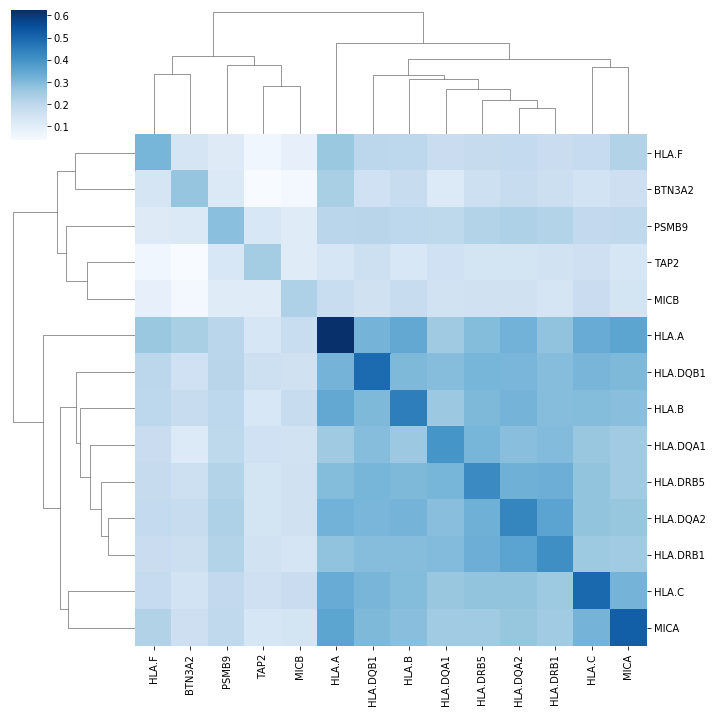

In [14]:
f=plt.figure(figsize=(10,10))
sns.clustermap(df_expand,cmap="Blues")
plt.savefig('../plots/hla.confusion.matrix.pdf')